## Setup

In [ ]:
# When working in AI LRZ
%cd ~/projects/cma_f 

In [1]:
import pandas as pd
import numpy as np
from joblib import load
import yaml

from utils import (
    compute_nc_scores,
    find_threshold,
    predict_conformal_sets,
    evaluate_sets
)

/Users/julia/Desktop/CMA_Fairness/cma_f/lib/python3.11/site-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/Users/julia/Desktop/CMA_Fairness/cma_f/lib/python3.11/site-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html

In [2]:
# Load universe definitions from YAML
with open("universes.yaml") as f:
    universes = yaml.safe_load(f)

In [3]:
# Determine unique model & feature_set combinations (each requires one model)
unique_combos = {(cfg["model"], cfg["feature_set"]) for cfg in universes}

## Data and Model Loading

In [4]:
X_calib_f = pd.read_csv("./output/X_calib_f.csv") # 2015, w. protected attributes
X_calib_s = pd.read_csv("./output/X_calib_s.csv") # 2015, w/o protected attributes
y_calib = pd.read_csv("./output/y_calib.csv").iloc[:,0]

X_test_f = pd.read_csv("./output/X_test_f.csv")
X_test_s = pd.read_csv("./output/X_test_s.csv")
y_test = pd.read_csv("./output/y_test.csv").iloc[:,0]

In [5]:
# Mapping from feature_set name to actual DataFrame, for convenience
feature_sets_calib = {
    "with_protected": X_calib_f,
    "without_protected": X_calib_s
}
feature_sets_test = {
    "with_protected": X_test_f,
    "without_protected": X_test_s
}

## Conformal

In [6]:
# Miscoverage level for conformal prediction (10% allowed error rate => 90% target coverage)
alpha = 0.10

In [7]:
# Helper function: given a trained model file and data, produce conformal prediction sets and metrics
def conformal_calibrate_and_evaluate(model_path, X_cal, y_cal, X_te, y_te, alpha):
    """Load model, compute conformal prediction sets on X_te using calibration set (X_cal, y_cal)."""
    model = load(model_path)
    # Compute nonconformity scores on calibration set (1 - probability of true class)
    probs_cal = model.predict_proba(X_cal)
    nc_scores = compute_nc_scores(probs_cal, y_cal)
    # Find conformal threshold q_hat for the given alpha (split conformal method)
    q_hat = find_threshold(nc_scores, alpha)
    # Generate prediction sets for each test example
    pred_sets = predict_conformal_sets(model, X_te, q_hat)
    # Evaluate coverage and average set size on test data
    metrics = evaluate_sets(pred_sets, y_te)
    return q_hat, metrics, pred_sets

In [8]:
# Run conformal prediction for each model type & feature set combination
conformal_results = {}  # to collect results for each universe combo
for model_type, feature_flag in sorted(unique_combos):
    # Identify the saved model file for this universe (matching training stage naming convention)
    model_filename = f"{model_type}_{feature_flag}.joblib"
    model_path = f"./models/{model_filename}"
    # Select the corresponding calibration and test feature sets
    X_cal = feature_sets_calib[feature_flag]
    X_te  = feature_sets_test[feature_flag]
    # Perform conformal calibration and evaluation
    q_hat, metrics, pred_sets = conformal_calibrate_and_evaluate(model_path, X_cal, y_calib, X_te, y_test, alpha)
    # Store results (coverage and average set size)
    conformal_results[(model_type, feature_flag)] = {
        "q_hat": q_hat,
        "coverage": metrics["coverage"],
        "avg_set_size": metrics["avg_size"]
    }
    # Print a summary of results for this model universe
    cov = metrics["coverage"]; avg = metrics["avg_size"]
    print(f"Model: {model_type} ({feature_flag} - Coverage: {cov:.3f}, Avg. Set Size: {avg:.2f}")

Model: logreg (with_protected - Coverage: 0.911, Avg. Set Size: 1.13
Model: logreg (without_protected - Coverage: 0.910, Avg. Set Size: 1.13
Model: penalized_logreg (with_protected - Coverage: 0.911, Avg. Set Size: 1.13
Model: penalized_logreg (without_protected - Coverage: 0.910, Avg. Set Size: 1.12
Model: rf (with_protected - Coverage: 0.915, Avg. Set Size: 1.15
Model: rf (without_protected - Coverage: 0.913, Avg. Set Size: 1.14


## Analyzing CP per subgroup 

In [18]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, balanced_accuracy_score

In [10]:
def conformal_prediction_sets(model, X_calib, y_calib, X_test, alpha=0.1):
    """
    Generate conformal prediction sets for X_test using calibration data (X_calib, y_calib).
    Returns a list of prediction sets (as Python sets of class labels) for each test sample.
    """
    # Compute nonconformity scores on calibration set (1 - probability of true class)
    probs_calib = model.predict_proba(X_calib)         # shape: (n_calib, n_classes)
    nc_scores = 1.0 - probs_calib[np.arange(len(y_calib)), y_calib]  # 1 - P(true_label)
    # Determine conformal threshold q_hat at level alpha
    q_hat = np.quantile(nc_scores, 1 - alpha, method="higher")
    # Compute nonconformity scores for each test sample and derive prediction sets
    probs_test = model.predict_proba(X_test)           # shape: (n_test, n_classes)
    nonconf_test = 1.0 - probs_test                    # nonconformity for each class
    pred_sets = [ set(np.where(nc_row <= q_hat)[0]) for nc_row in nonconf_test ]
    return pred_sets

In [11]:
def build_cp_groups(pred_sets, y_test, test_idx, X_test_full):
    """
    Build a DataFrame of conformal prediction results with subgroup info.
    - pred_sets: list of prediction sets for each test sample (in order of test_idx).
    - y_test: Series or array of true labels for test samples.
    - test_idx: index of the test samples corresponding to pred_sets.
    - X_test_full: DataFrame of test features **including protected attributes**.
    """
    cp_df = pd.DataFrame(index=test_idx.copy())
    # Store prediction sets (convert each to a set of ints for consistency)
    cp_df['pred_set']   = pd.Series(pred_sets, index=test_idx).apply(lambda s: {int(x) for x in s})
    cp_df['true_label'] = y_test.reindex(test_idx)
    # Bring in protected attributes from the full test set
    cp_df['frau1']    = X_test_full.loc[test_idx, 'frau1']          # 1 = female, 0 = male
    # Derive 'nongerman' flag ('maxdeutsch1' indicates German (1) vs non-German (0))
    cp_df['nongerman'] = np.where(X_test_full.loc[test_idx, 'maxdeutsch1'] == 0, 1, 0)
    # Handle missing nationality information if applicable
    if 'maxdeutsch.Missing.' in X_test_full.columns:
        missing_mask = (X_test_full.loc[test_idx, 'maxdeutsch.Missing.'] == 1)
        cp_df.loc[missing_mask, 'nongerman'] = np.nan
    # Derive intersectional subgroup flags
    cp_df['nongerman_male']   = np.where((cp_df['nongerman'] == 1) & (cp_df['frau1'] == 0), 1, 0)
    cp_df['nongerman_female'] = np.where((cp_df['nongerman'] == 1) & (cp_df['frau1'] == 1), 1, 0)
    # (Optional) drop samples with missing subgroup info
    cp_df = cp_df.dropna(subset=['nongerman'])
    return cp_df

In [25]:
def compute_subgroup_metrics(cp_df):
    """
    Compute accuracy, precision, recall, F1, and balanced accuracy for overall and each subgroup in cp_df.
    Considers only single-label prediction sets as definite predictions.
    """
    results = {}
    # Convert prediction sets to list for easier handling
    pred_sets_list = cp_df['pred_set'].tolist()
    y_true = np.array(cp_df['true_label'])
    # Identify non-ambiguous (single-label) predictions
    is_single = np.array([len(s) == 1 for s in pred_sets_list])
    # Overall metrics for all single predictions
    if np.any(is_single):
        y_true_single = y_true[is_single]
        # Extract the single predicted label from each singleton set
        y_pred_single = [next(iter(s)) for s, flag in zip(pred_sets_list, is_single) if flag]
        # Compute confusion matrix and metrics
        tn, fp, fn, tp = confusion_matrix(y_true_single, y_pred_single, labels=[0, 1]).ravel()
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true_single, y_pred_single, average="binary", zero_division=0
        )
        bal_acc = balanced_accuracy_score(y_true_single, y_pred_single)

        results["overall"] = {
            "TP": tp, "TN": tn, "FP": fp, "FN": fn,
            "Accuracy": (tp + tn) / (tp + tn + fp + fn) if (tp+tn+fp+fn) > 0 else 0.0,
            "Precision": precision, "Recall": recall, "F1": f1, "Bal_acc": bal_acc,
            "Num_Samples": len(y_true_single),
            "Frac_NonAmbiguous": np.mean(is_single)  # fraction of test samples with a single-label pred
        }
    else:
        # If no single-label predictions, overall metrics are all zero/none
        # ???? check if this is desired behavior
        results["overall"] = {
            "TP": 0, "TN": 0, "FP": 0, "FN": 0,
            "Accuracy": 0.0, "Precision": 0.0, "Recall": 0.0, "F1": 0.0, "Bal_acc": 0.0,
            "Num_Samples": 0, "Frac_NonAmbiguous": 0.0
        }
    # List of subgroup columns to evaluate (1 indicates membership in subgroup)
    subgroup_cols = ["frau1", "nongerman", "nongerman_male", "nongerman_female"]
    for col in subgroup_cols:
        mask = (cp_df[col] == 1).to_numpy() & is_single  # members of subgroup with definite predictions
        if np.any(mask):
            y_true_sub = y_true[mask]
            y_pred_sub = [next(iter(s)) for s, flag in zip(pred_sets_list, mask) if flag]
            tn, fp, fn, tp = confusion_matrix(y_true_sub, y_pred_sub, labels=[0, 1]).ravel()
            precision, recall, f1, _ = precision_recall_fscore_support(
                y_true_sub, y_pred_sub, average="binary", zero_division=0
            )
            bal_acc = balanced_accuracy_score(y_true_sub, y_pred_sub)

            results[col] = {
                "TP": tp, "TN": tn, "FP": fp, "FN": fn,
                "Accuracy": (tp + tn) / (tp + tn + fp + fn) if (tp+tn+fp+fn) > 0 else 0.0,
                "Precision": precision, "Recall": recall, "F1": f1, "Bal_acc": bal_acc,
                "Num_Samples": len(y_true_sub),
                # Fraction of subgroup's samples with a single-label prediction
                "Frac_NonAmbiguous": np.mean(is_single[cp_df[col] == 1])
            }
        else:
            results[col] = None  # No definite predictions (or no samples) in this subgroup
            
    metrics_df = pd.DataFrame(results).T
    metrics_df.index.name = 'Subgroup'
    return metrics_df

In [ ]:
# 2. Use the above functions in the analysis workflow
# Example for a single universe or model configuration:
#model_path = "./models/logreg_with_protected.joblib"
#model = load(model_path)
## Use appropriate feature sets depending on model (with or without protected)
#X_calib = X_calib_f   # (assuming this model uses protected attributes)
#X_test  = X_test_f
## Generate conformal prediction sets for this model
#pred_sets = conformal_prediction_sets(model, X_calib, y_calib.to_numpy(), X_test, alpha=0.1)
## Build the cp_groups DataFrame with true labels and group info
#cp_groups_df = build_cp_groups(pred_sets, y_test, X_test.index, X_test_f)
## Compute subgroup metrics
#metrics = compute_subgroup_metrics(cp_groups_df)
#print(metrics)


In [26]:
# 2. Compute metrics for each universe in universes
metrics_by_universe = {}
records = []

for model_type, feature_flag in unique_combos:
    universe_id = f"{model_type}_{feature_flag}"
    model_path = f"./models/{universe_id}.joblib"
    model = load(model_path)

    if feature_flag == "with_protected":
        X_calib, X_test = X_calib_f, X_test_f
    else:
        X_calib, X_test = X_calib_s, X_test_s

    pred_sets = conformal_prediction_sets(model, X_calib, y_calib.to_numpy(), X_test, alpha=0.1)
    cp_groups_df = build_cp_groups(pred_sets, y_test, X_test.index, X_test_f)
    metrics = compute_subgroup_metrics(cp_groups_df)
    
    # Add balanced accuracy to each subgroup row (same method as f1)
    
    metrics_by_universe[universe_id] = metrics

    for subgroup, row in metrics.iterrows():
        if row is not None:
            row_dict = row.to_dict()
            row_dict.update({
                "UniverseID": universe_id,
                "Model": model_type,
                "FeatureSet": feature_flag,
                "Subgroup": subgroup
            })
            records.append(row_dict)

# Combine into a single DataFrame
all_metrics_df = pd.DataFrame(records)

In [27]:
all_metrics_df.to_csv("./output/conformal_subgroup_metrics.csv", index=False)


# Visualizations

In [15]:
target_universe_id = "penalized_logreg_with_protected"

subset_df = all_metrics_df[all_metrics_df["UniverseID"] == target_universe_id].drop(columns=["Model", "FeatureSet"])

# Reorder columns: UniverseID, Subgroup, then the rest
cols = ["UniverseID", "Subgroup"] + [col for col in subset_df.columns if col not in ["UniverseID", "Subgroup"]]
subset_df = subset_df[cols]

print(subset_df)

                         UniverseID          Subgroup     TP       TN     FP  \
25  penalized_logreg_with_protected           overall  340.0  68059.0  439.0   
26  penalized_logreg_with_protected             frau1  115.0  28442.0  171.0   
27  penalized_logreg_with_protected         nongerman   36.0  14880.0   34.0   
28  penalized_logreg_with_protected    nongerman_male   22.0   9690.0   15.0   
29  penalized_logreg_with_protected  nongerman_female   14.0   5190.0   19.0   

        FN  Accuracy  Precision    Recall        F1  Num_Samples  \
25  7307.0  0.898273   0.436457  0.044462  0.080703      76145.0   
26  3187.0  0.894783   0.402098  0.034827  0.064103      31915.0   
27  1515.0  0.905922   0.514286  0.023211  0.044417      16465.0   
28   773.0  0.924952   0.594595  0.027673  0.052885      10500.0   
29   742.0  0.872422   0.424242  0.018519  0.035488       5965.0   

    Frac_NonAmbiguous  
25           0.875401  
26           0.860359  
27           0.924325  
28           0

/var/folders/h7/6qcvyjh51cg86vrxn3xs8c_40000gn/T/ipykernel_31874/3391936826.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


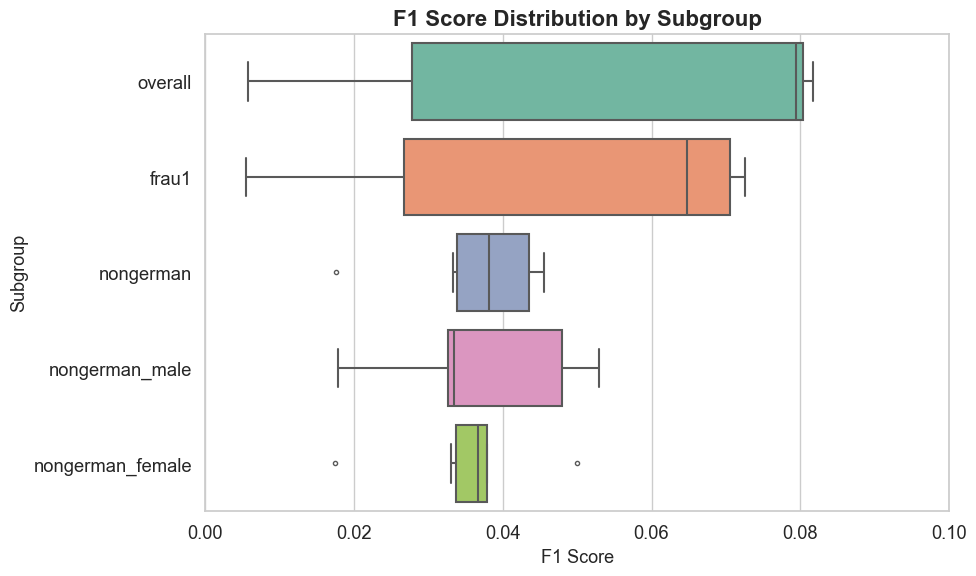

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid", font_scale=1.2)

# Drop rows with missing F1 scores
filtered_df = all_metrics_df.dropna(subset=["F1"])

# Count number of observations per subgroup for annotation
subgroup_counts = filtered_df["Subgroup"].value_counts()

# Create figure
plt.figure(figsize=(10, 6))

# Custom color palette
palette = sns.color_palette("Set2", n_colors=5)

# Horizontal boxplot (f1 on x-axis)
ax = sns.boxplot(
    y="Subgroup",
    x="F1",
    data=filtered_df,
    palette=palette,
    linewidth=1.5,
    fliersize=3
)

# Annotate with number of data points
for i, subgroup in enumerate(ax.get_yticklabels()):
    count = subgroup_counts.get(subgroup.get_text(), 0)
    #ax.text(0.02, i, f"n={count}", ha='left', va='center', fontsize=10, color='gray')

# Axis labels and title
ax.set_title("F1 Score Distribution by Subgroup", fontsize=16, weight='bold')
ax.set_xlabel("F1 Score", fontsize=13)
ax.set_ylabel("Subgroup", fontsize=13)
plt.xlim(0, 0.1)

# Final layout adjustments
plt.tight_layout()
plt.show()


/var/folders/h7/6qcvyjh51cg86vrxn3xs8c_40000gn/T/ipykernel_31874/2280318459.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


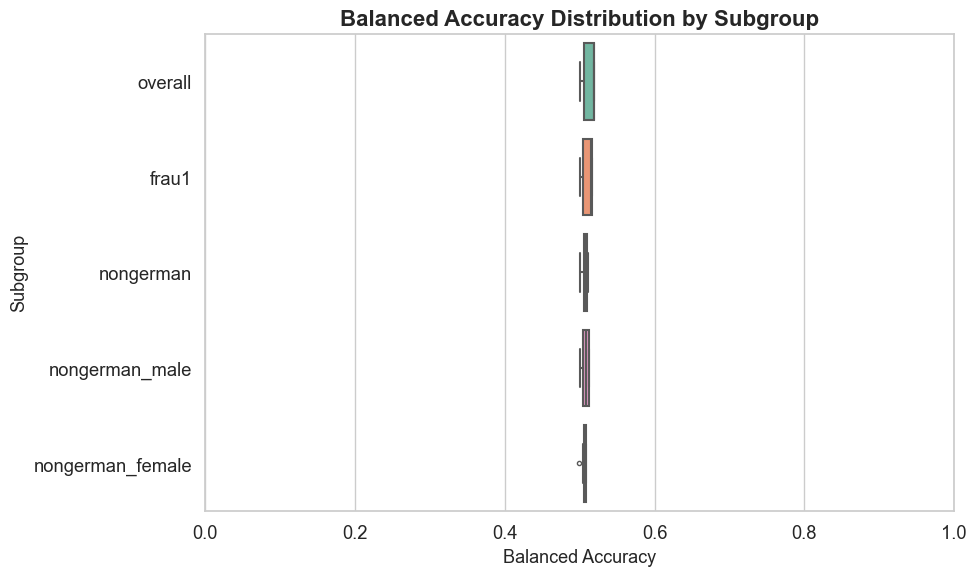

In [30]:
# Set plot style
sns.set(style="whitegrid", font_scale=1.2)

# Drop rows with missing Balanced Accuracy scores
filtered_df = all_metrics_df.dropna(subset=["Bal_acc"])

# Count number of observations per subgroup for annotation
subgroup_counts = filtered_df["Subgroup"].value_counts()

# Create figure
plt.figure(figsize=(10, 6))

# Custom color palette
palette = sns.color_palette("Set2", n_colors=5)

# Horizontal boxplot (Balanced Accuracy on x-axis)
ax = sns.boxplot(
    y="Subgroup",
    x="Bal_acc",
    data=filtered_df,
    palette=palette,
    linewidth=1.5,
    fliersize=3
)

# Annotate with number of data points (commented out)
# for i, subgroup in enumerate(ax.get_yticklabels()):
#     count = subgroup_counts.get(subgroup.get_text(), 0)
#     ax.text(0.02, i, f"n={count}", ha='left', va='center', fontsize=10, color='gray')

# Axis labels and title
ax.set_title("Balanced Accuracy Distribution by Subgroup", fontsize=16, weight='bold')
ax.set_xlabel("Balanced Accuracy", fontsize=13)
ax.set_ylabel("Subgroup", fontsize=13)
plt.xlim(0, 1)

# Final layout adjustments
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid", font_scale=1.2)

# Drop rows with missing values for the target metric
filtered_df = all_metrics_df.dropna(subset=["Frac_NonAmbiguous"])

# Count number of observations per subgroup for annotation
subgroup_counts = filtered_df["Subgroup"].value_counts()

# Create figure
plt.figure(figsize=(10, 6))

# Custom color palette
palette = sns.color_palette("Set2", n_colors=5)

# Horizontal boxplot: Frac_NonAmbiguous on x-axis
ax = sns.boxplot(
    y="Subgroup",
    x="Frac_NonAmbiguous",
    data=filtered_df,
    palette=palette,
    linewidth=1.5,
    fliersize=3
)

# Annotate with number of data points
for i, subgroup in enumerate(ax.get_yticklabels()):
    count = subgroup_counts.get(subgroup.get_text(), 0)
    #ax.text(0.005, i, f"n={count}", ha='left', va='center', fontsize=10, color='gray')

# Axis labels and title
ax.set_title("Fraction of Non-Ambiguous Predictions by Subgroup", fontsize=16, weight='bold')
ax.set_xlabel("Fraction Non-Ambiguous", fontsize=13)
ax.set_ylabel("Subgroup", fontsize=13)
plt.xlim(0.8, 1)

# Final layout adjustments
plt.tight_layout()
plt.show()


# Modified multiverse loop (with prediction collection)

In [ ]:
# Prepare a list to collect per-universe prediction DataFrames
all_predictions_list = []

for i, cfg in enumerate(universes):
    model_type      = cfg["model"]
    feature_flag    = cfg["feature_set"]
    threshold_policy = cfg.get("threshold_policy", "standard")  # use actual key if present

    # Identify model file and corresponding data sets
    model_path = f"./models/{model_type}_{feature_flag}.joblib"
    X_cal = feature_sets_calib[feature_flag]    # calibration features (with/without protected as per feature_flag)
    X_te = feature_sets_test[feature_flag]      # test features (with/without protected)
    
    # Perform conformal prediction for this universe (calibrate and get prediction sets)
    q_hat, metrics, pred_sets = conformal_calibrate_and_evaluate(model_path, 
                                                                 X_cal, y_calib, 
                                                                 X_te, y_test, alpha)
    # `pred_sets` is a list of predicted label sets for each test sample in this universe.
    # Now build a DataFrame for this universe's predictions:
    test_idx = X_te.index.copy()  # indices of the test samples for this run
    cp_df = build_cp_groups(pred_sets, y_test, test_idx, X_test_f)
    # `build_cp_groups` will add columns: pred_set, true_label, frau1, nongerman, etc.
    # (It uses X_test_f as the full test set with protected attributes:contentReference[oaicite:1]{index=1}.)

    # Add columns identifying the decision configuration for this prediction
    cp_df["model"]           = model_type
    cp_df["feature_set"]     = feature_flag
    cp_df["threshold_policy"] = threshold_policy
    cp_df["UniverseID"]      = cfg["id"]  
    
    # Collect this universe's prediction dataframe
    all_predictions_list.append(cp_df)

# Combine all universes into one DataFrame
all_preds_df = pd.concat(all_predictions_list, ignore_index=True)

print(f"Total predictions collected: {len(all_preds_df)} rows")
# Each row is one test-sample prediction under one universe (decision combo).
# Let's preview the columns:
print(all_preds_df.columns.tolist())


In [ ]:
# Save the full predictions DataFrame to disk for reuse
all_preds_df.to_csv("./data/all_universe_predictions.csv", index=False)


In [ ]:
all_preds_df.head()

In [ ]:
# If separate files per universe are preferred
#for u_id, cp_df in enumerate(all_predictions_list):
#    cp_df.to_csv(f"predictions_universe_{u_id}.csv", index=False)


# Visualizations

In [ ]:
# Create a helper column for pred_set type as string
all_preds_df['pred_set_str'] = all_preds_df['pred_set'].apply(lambda s: str(sorted(s)))

In [ ]:
# Define subgroups to analyze (including 'overall')
subgroups = ['overall', 'frau1', 'nongerman', 'nongerman_male', 'nongerman_female']
subgroup_labels = {
    'overall': 'Overall',
    'frau1': 'Female',
    'nongerman': 'Non-German',
    'nongerman_male': 'Non-German Male',
    'nongerman_female': 'Non-German Female'
}


In [ ]:
# Prepare data for plotting
plot_data = []
for subgroup in subgroups:
    if subgroup == 'overall':
        subgroup_df = all_preds_df.copy()
    else:
        subgroup_df = all_preds_df[all_preds_df[subgroup] == 1]

    for universe, universe_df in subgroup_df.groupby('UniverseID'):
        counts = universe_df['pred_set_str'].value_counts(normalize=True)
        for pred_set_type in ['[0]', '[1]', '[0, 1]']:
            plot_data.append({
                'subgroup': subgroup_labels[subgroup],
                'pred_set': pred_set_type,
                'UniverseID': universe,
                'fraction': counts.get(pred_set_type, 0)
            })

plot_df = pd.DataFrame(plot_data)

In [ ]:
# Compute mean and std deviation across universes
summary_df = plot_df.groupby(['subgroup', 'pred_set']).agg(
    mean_fraction=('fraction', 'mean'),
    std_fraction=('fraction', 'std')
).reset_index()

In [ ]:
# Sort subgroups for consistent plotting
ordered_labels = [subgroup_labels[s] for s in subgroups]
summary_df['subgroup'] = pd.Categorical(summary_df['subgroup'], categories=ordered_labels, ordered=True)


In [ ]:
# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=summary_df,
    x='subgroup',
    y='mean_fraction',
    hue='pred_set',
    palette='Set2',
    capsize=0.1,
    err_kws={'color': 'black'}
)

plt.title('Distribution of Conformal Prediction Set Types by Subgroup')
plt.ylabel('Fraction of Predictions')
plt.xlabel('Subgroup')
plt.ylim(0, 1)
plt.legend(title='Prediction Set')
plt.tight_layout()
plt.show()

In [ ]:
# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=summary_df,
    x='subgroup',
    y='mean_fraction',
    hue='pred_set',
    palette='Set2',
    capsize=0.1,
    err_kws={'color': 'black'}
)

plt.title('Distribution of Conformal Prediction Set Types by Subgroup')
plt.ylabel('Fraction of Predictions')
plt.xlabel('Subgroup')
plt.ylim(0, 0.175)
plt.legend(title='Prediction Set')
plt.tight_layout()
plt.show()

In [ ]:
# Plot with seaborn's internal error estimation
plt.figure(figsize=(12, 6))
sns.barplot(
    data=plot_df,
    x='subgroup',
    y='fraction',
    hue='pred_set',
    palette='Set2',
    capsize=0.1,
    err_kws={'color': 'black'},  # <-- HIGHLIGHT: replaced deprecated 'errcolor' with 'err_kws'
    estimator='mean',            # <-- HIGHLIGHT: explicitly defined the estimator
    ci='sd'                      # <-- HIGHLIGHT: added standard deviation-based error bars
)

plt.title('Distribution of Conformal Prediction Set Types by Subgroup')
plt.ylabel('Fraction of Predictions')
plt.xlabel('Subgroup')
plt.ylim(0, 1)
plt.legend(title='Prediction Set')
plt.tight_layout()
plt.show()

In [ ]:
# Plot with seaborn's internal error estimation
plt.figure(figsize=(12, 6))
sns.barplot(
    data=plot_df,
    x='subgroup',
    y='fraction',
    hue='pred_set',
    palette='Set2',
    capsize=0.1,
    err_kws={'color': 'black'},  # <-- HIGHLIGHT: replaced deprecated 'errcolor' with 'err_kws'
    estimator='mean',            # <-- HIGHLIGHT: explicitly defined the estimator
    ci='sd'                      # <-- HIGHLIGHT: added standard deviation-based error bars
)

plt.title('Distribution of Conformal Prediction Set Types by Subgroup')
plt.ylabel('Fraction of Predictions')
plt.xlabel('Subgroup')
plt.ylim(0, 0.175)
plt.legend(title='Prediction Set')
plt.tight_layout()
plt.show()

Can you add to the [0] and [1] prediction sets the "true_label" fractions per subgroup?

In [ ]:
# Prepare data for plotting
plot_data = []
for subgroup in subgroups:
    if subgroup == 'overall':
        subgroup_df = all_preds_df.copy()
    else:
        subgroup_df = all_preds_df[all_preds_df[subgroup] == 1]

    for universe, universe_df in subgroup_df.groupby('UniverseID'):
        counts = universe_df['pred_set_str'].value_counts(normalize=True)
        for pred_set_type in ['[0]', '[1]', '[0, 1]']:
            plot_data.append({
                'subgroup': subgroup_labels[subgroup],
                'pred_set': pred_set_type,
                'UniverseID': universe,
                'fraction': counts.get(pred_set_type, 0)
            })

        # Add true label fractions for comparison
        for label in [0, 1]:
            label_fraction = (universe_df['true_label'] == label).mean()
            plot_data.append({
                'subgroup': subgroup_labels[subgroup],
                'pred_set': f'true={label}',
                'UniverseID': universe,
                'fraction': label_fraction
            })

plot_df = pd.DataFrame(plot_data)


In [ ]:
# Sort subgroups for consistent plotting
ordered_labels = [subgroup_labels[s] for s in subgroups]
plot_df['subgroup'] = pd.Categorical(plot_df['subgroup'], categories=ordered_labels, ordered=True)

hue_order = ['[0]', 'true=0', '[1]', 'true=1', '[0, 1]']

# Plot with seaborn's internal error estimation
plt.figure(figsize=(12, 6))
sns.barplot(
    data=plot_df,
    x='subgroup',
    y='fraction',
    hue='pred_set',
    hue_order=hue_order,
    palette='Set2',
    capsize=0.1,
    err_kws={'color': 'black'},
    estimator='mean',
    ci='sd'
)

plt.title('Distribution of Conformal Prediction Set Types and True Labels by Subgroup')
plt.ylabel('Fraction')
plt.xlabel('Subgroup')
plt.ylim(0, 1)
plt.legend(title='Prediction Set / True Label')
plt.tight_layout()
plt.show()

In [ ]:
# Sort subgroups for consistent plotting
ordered_labels = [subgroup_labels[s] for s in subgroups]
plot_df['subgroup'] = pd.Categorical(plot_df['subgroup'], categories=ordered_labels, ordered=True)

hue_order = ['[0]', 'true=0', '[1]', 'true=1', '[0, 1]']

# Plot with seaborn's internal error estimation
plt.figure(figsize=(12, 6))
sns.barplot(
    data=plot_df,
    x='subgroup',
    y='fraction',
    hue='pred_set',
    hue_order=hue_order,
    palette='Set2',
    capsize=0.1,
    err_kws={'color': 'black'},
    estimator='mean',
    ci='sd'
)

plt.title('Distribution of Conformal Prediction Set Types and True Labels by Subgroup')
plt.ylabel('Fraction')
plt.xlabel('Subgroup')
plt.ylim(0, 0.175)
plt.legend(title='Prediction Set / True Label')
plt.tight_layout()
plt.show()

# Pie Diagrams

In [ ]:
# Check code for correctness

# Validate input columns
assert 'pred_set' in all_preds_df.columns, "Missing 'pred_set' column"
assert 'true_label' in all_preds_df.columns, "Missing 'true_label' column"

# Create pred_set_str explicitly from pred_set if needed
if 'pred_set_str' not in all_preds_df.columns:
    all_preds_df['pred_set_str'] = all_preds_df['pred_set'].apply(lambda x: str(sorted(x)))

# Print unique values for checking
print("Unique pred_set_str values:", all_preds_df['pred_set_str'].unique())

# Define subgroups
subgroups = {
    'overall': all_preds_df,
    'female': all_preds_df[all_preds_df['frau1'] == 1],
    'nongerman': all_preds_df[all_preds_df['nongerman'] == 1],
    'nongerman_male': all_preds_df[all_preds_df['nongerman_male'] == 1],
    'nongerman_female': all_preds_df[all_preds_df['nongerman_female'] == 1]
}

# Match transformed values from pred_set to pred_set_str
prediction_sets = ['[0]', '[1]', '[0, 1]']  # Note: brackets from list -> string conversion
colors = ['#66c2a5', '#fc8d62']

for name, subset in subgroups.items():
    print(f"\n--- Subgroup: {name} ---")
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"{name.capitalize()} - Distribution of True Labels per Prediction Set")

    for i, pred_str in enumerate(prediction_sets):
        selected = subset[subset['pred_set_str'] == pred_str]
        true_counts = selected['true_label'].value_counts().reindex([0, 1], fill_value=0)
        print(f"Prediction: {pred_str}, Counts: {true_counts.to_dict()}")

        if true_counts.sum() == 0:
            axes[i].text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=12)
            axes[i].set_title(f"Prediction: {pred_str}")
            axes[i].axis('off')
        else:
            axes[i].pie(true_counts, labels=['True 0', 'True 1'], autopct='%1.1f%%', colors=colors)
            axes[i].set_title(f"Prediction: {pred_str}")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
